In [ ]:
!pip install niapy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 kB 6.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import joblib

from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score

import niapy

from niapy.problems import Problem
from niapy.task import Task
from niapy.algorithms.basic import CamelAlgorithm

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/TA

Mounted at /content/drive
/content/drive/MyDrive/TA


In [ ]:
class SVRFeatureSelection(Problem):
    def __init__(self, X_train, y_train, alpha=0.8):
        super().__init__(dimension=X_train.shape[1], lower=0, upper=1)
        self.X_train = X_train
        self.y_train = y_train
        self.alpha = alpha

    def _evaluate(self, x):
        selected = x > 0.5
        num_selected = selected.sum()
        if num_selected == 0:
            return 1.0
        accuracy = cross_val_score(SVR(kernel="poly"), self.X_train.loc[:, selected], self.y_train, cv=10, n_jobs=-1,scoring='r2').mean()
        #accuracy = cross_val_score(SVR(kernel="rbf"), self.X_train[:, selected], self.y_train, cv=10, n_jobs=-1, scoring='r2').mean()
        score = 1 - accuracy
        num_features = self.X_train.shape[1]
        return (self.alpha * score) + (1 - self.alpha) * (num_selected / num_features)

In [ ]:
#LOAD DATASET
df_train = pd.read_csv('Train.csv')

In [ ]:
df_train.isna().any().any()

False

In [ ]:
print("Contains Inf:", np.isinf(df_train).any().any())

infinite_columns = df_train.columns[np.isinf(df_train).any()]

print("\nColumns containing infinite values:")
print(infinite_columns.tolist())

Contains Inf: False

Columns containing infinite values:
[]


In [ ]:
X_train = df_train.drop(columns=["Pic50"], axis=1)
y_train = df_train["Pic50"]

In [ ]:
print(X_train)

     PubchemFP0  PubchemFP1  PubchemFP2  PubchemFP3  PubchemFP4  PubchemFP5  \
0             1           1           1           0           0           0   
1             1           1           1           0           0           0   
2             1           1           1           0           0           0   
3             1           1           1           1           0           0   
4             1           1           1           0           0           0   
..          ...         ...         ...         ...         ...         ...   
191           1           1           1           0           0           0   
192           1           1           1           0           0           0   
193           1           1           1           0           0           0   
194           1           1           1           0           0           0   
195           1           1           1           1           0           0   

     PubchemFP6  PubchemFP7  PubchemFP8  PubchemFP9

In [ ]:
print(y_train)

0      7.000000
1      7.481486
2      9.455932
3      9.154902
4      6.396374
         ...   
191    8.823909
192    3.602060
193    3.602060
194    8.397940
195    8.301030
Name: Pic50, Length: 196, dtype: float64


In [ ]:
problem = SVRFeatureSelection(X_train, y_train)
task = Task(problem, max_iters=20)
algorithm = CamelAlgorithm(population_size=30, burden_factor=0.5, supply_init=25, endurance_init=25, seed=1234)
best_features, best_fitness = algorithm.run(task)

In [ ]:
feature_name = X_train.columns

selected_features = best_features > 0.5
print('Number of selected features:', selected_features.sum())
print('Selected features:', ', '.join(feature_name[selected_features].tolist()))

Number of selected features: 405
Selected features: PubchemFP2, PubchemFP8, PubchemFP10, PubchemFP13, PubchemFP15, PubchemFP16, PubchemFP23, PubchemFP26, PubchemFP27, PubchemFP28, PubchemFP32, PubchemFP36, PubchemFP37, PubchemFP39, PubchemFP42, PubchemFP47, PubchemFP51, PubchemFP52, PubchemFP54, PubchemFP56, PubchemFP57, PubchemFP63, PubchemFP65, PubchemFP68, PubchemFP71, PubchemFP72, PubchemFP73, PubchemFP74, PubchemFP78, PubchemFP81, PubchemFP84, PubchemFP90, PubchemFP92, PubchemFP93, PubchemFP95, PubchemFP96, PubchemFP98, PubchemFP102, PubchemFP104, PubchemFP107, PubchemFP109, PubchemFP110, PubchemFP113, PubchemFP115, PubchemFP117, PubchemFP119, PubchemFP123, PubchemFP124, PubchemFP125, PubchemFP126, PubchemFP128, PubchemFP132, PubchemFP133, PubchemFP137, PubchemFP139, PubchemFP140, PubchemFP141, PubchemFP143, PubchemFP144, PubchemFP145, PubchemFP149, PubchemFP153, PubchemFP154, PubchemFP155, PubchemFP157, PubchemFP159, PubchemFP160, PubchemFP161, PubchemFP163, PubchemFP164, Pubchem

In [ ]:
# Model SVR untuk regresi
model_all = SVR(kernel='poly')
# Menghitung akurasi menggunakan cross-validation
score_all = cross_val_score(model_all, X_train, y_train, scoring='r2', cv=10, n_jobs=-1).mean()
print('All Features R2 Accuracy:', score_all)


All Features R2 Accuracy: 0.5200059783515193


In [ ]:
model_selected = SVR(kernel='poly')
X_train_selected = X_train.iloc[:, selected_features]
score_select = cross_val_score(model_selected, X_train_selected, y_train, scoring='r2', cv=10, n_jobs=-1).mean()
print('Selected Features R2 Accuracy:', score_select)

Selected Features R2 Accuracy: 0.555997478733813


In [ ]:
selected_feature = feature_name[selected_features].tolist()
joblib.dump(selected_feature,"selected_feature_poly.pkl")

['selected_feature_poly.pkl']

In [ ]:
feature_selected = joblib.load("selected_feature_poly.pkl")
feature_selected

['PubchemFP2',
 'PubchemFP8',
 'PubchemFP10',
 'PubchemFP13',
 'PubchemFP15',
 'PubchemFP16',
 'PubchemFP23',
 'PubchemFP26',
 'PubchemFP27',
 'PubchemFP28',
 'PubchemFP32',
 'PubchemFP36',
 'PubchemFP37',
 'PubchemFP39',
 'PubchemFP42',
 'PubchemFP47',
 'PubchemFP51',
 'PubchemFP52',
 'PubchemFP54',
 'PubchemFP56',
 'PubchemFP57',
 'PubchemFP63',
 'PubchemFP65',
 'PubchemFP68',
 'PubchemFP71',
 'PubchemFP72',
 'PubchemFP73',
 'PubchemFP74',
 'PubchemFP78',
 'PubchemFP81',
 'PubchemFP84',
 'PubchemFP90',
 'PubchemFP92',
 'PubchemFP93',
 'PubchemFP95',
 'PubchemFP96',
 'PubchemFP98',
 'PubchemFP102',
 'PubchemFP104',
 'PubchemFP107',
 'PubchemFP109',
 'PubchemFP110',
 'PubchemFP113',
 'PubchemFP115',
 'PubchemFP117',
 'PubchemFP119',
 'PubchemFP123',
 'PubchemFP124',
 'PubchemFP125',
 'PubchemFP126',
 'PubchemFP128',
 'PubchemFP132',
 'PubchemFP133',
 'PubchemFP137',
 'PubchemFP139',
 'PubchemFP140',
 'PubchemFP141',
 'PubchemFP143',
 'PubchemFP144',
 'PubchemFP145',
 'PubchemFP149',
 '

In [ ]:
task.convergence_data()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 array([0.46874639, 0.46874639, 0.45190734, 0.44939489, 0.44939489,
        0.44912171, 0.44912171, 0.44912171, 0.44874785, 0.44874785,
        0.44849769, 0.44714299, 0.44714299, 0.44714299, 0.44714299,
        0.44714299, 0.44714299, 0.44714299, 0.44714299, 0.44714299]))

In [ ]:
convergence_data = task.convergence_data()
convergence_data


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 array([0.46874639, 0.46874639, 0.45190734, 0.44939489, 0.44939489,
        0.44912171, 0.44912171, 0.44912171, 0.44874785, 0.44874785,
        0.44849769, 0.44714299, 0.44714299, 0.44714299, 0.44714299,
        0.44714299, 0.44714299, 0.44714299, 0.44714299, 0.44714299]))

In [ ]:
joblib.dump(convergence_data,"convergence_data_poly.pkl")

['convergence_data_poly.pkl']

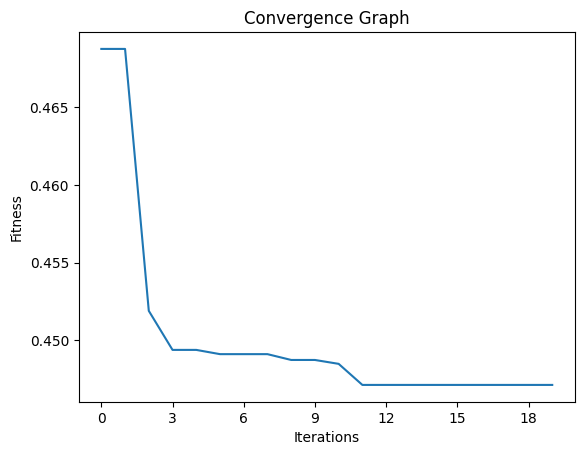

In [ ]:
task.plot_convergence()